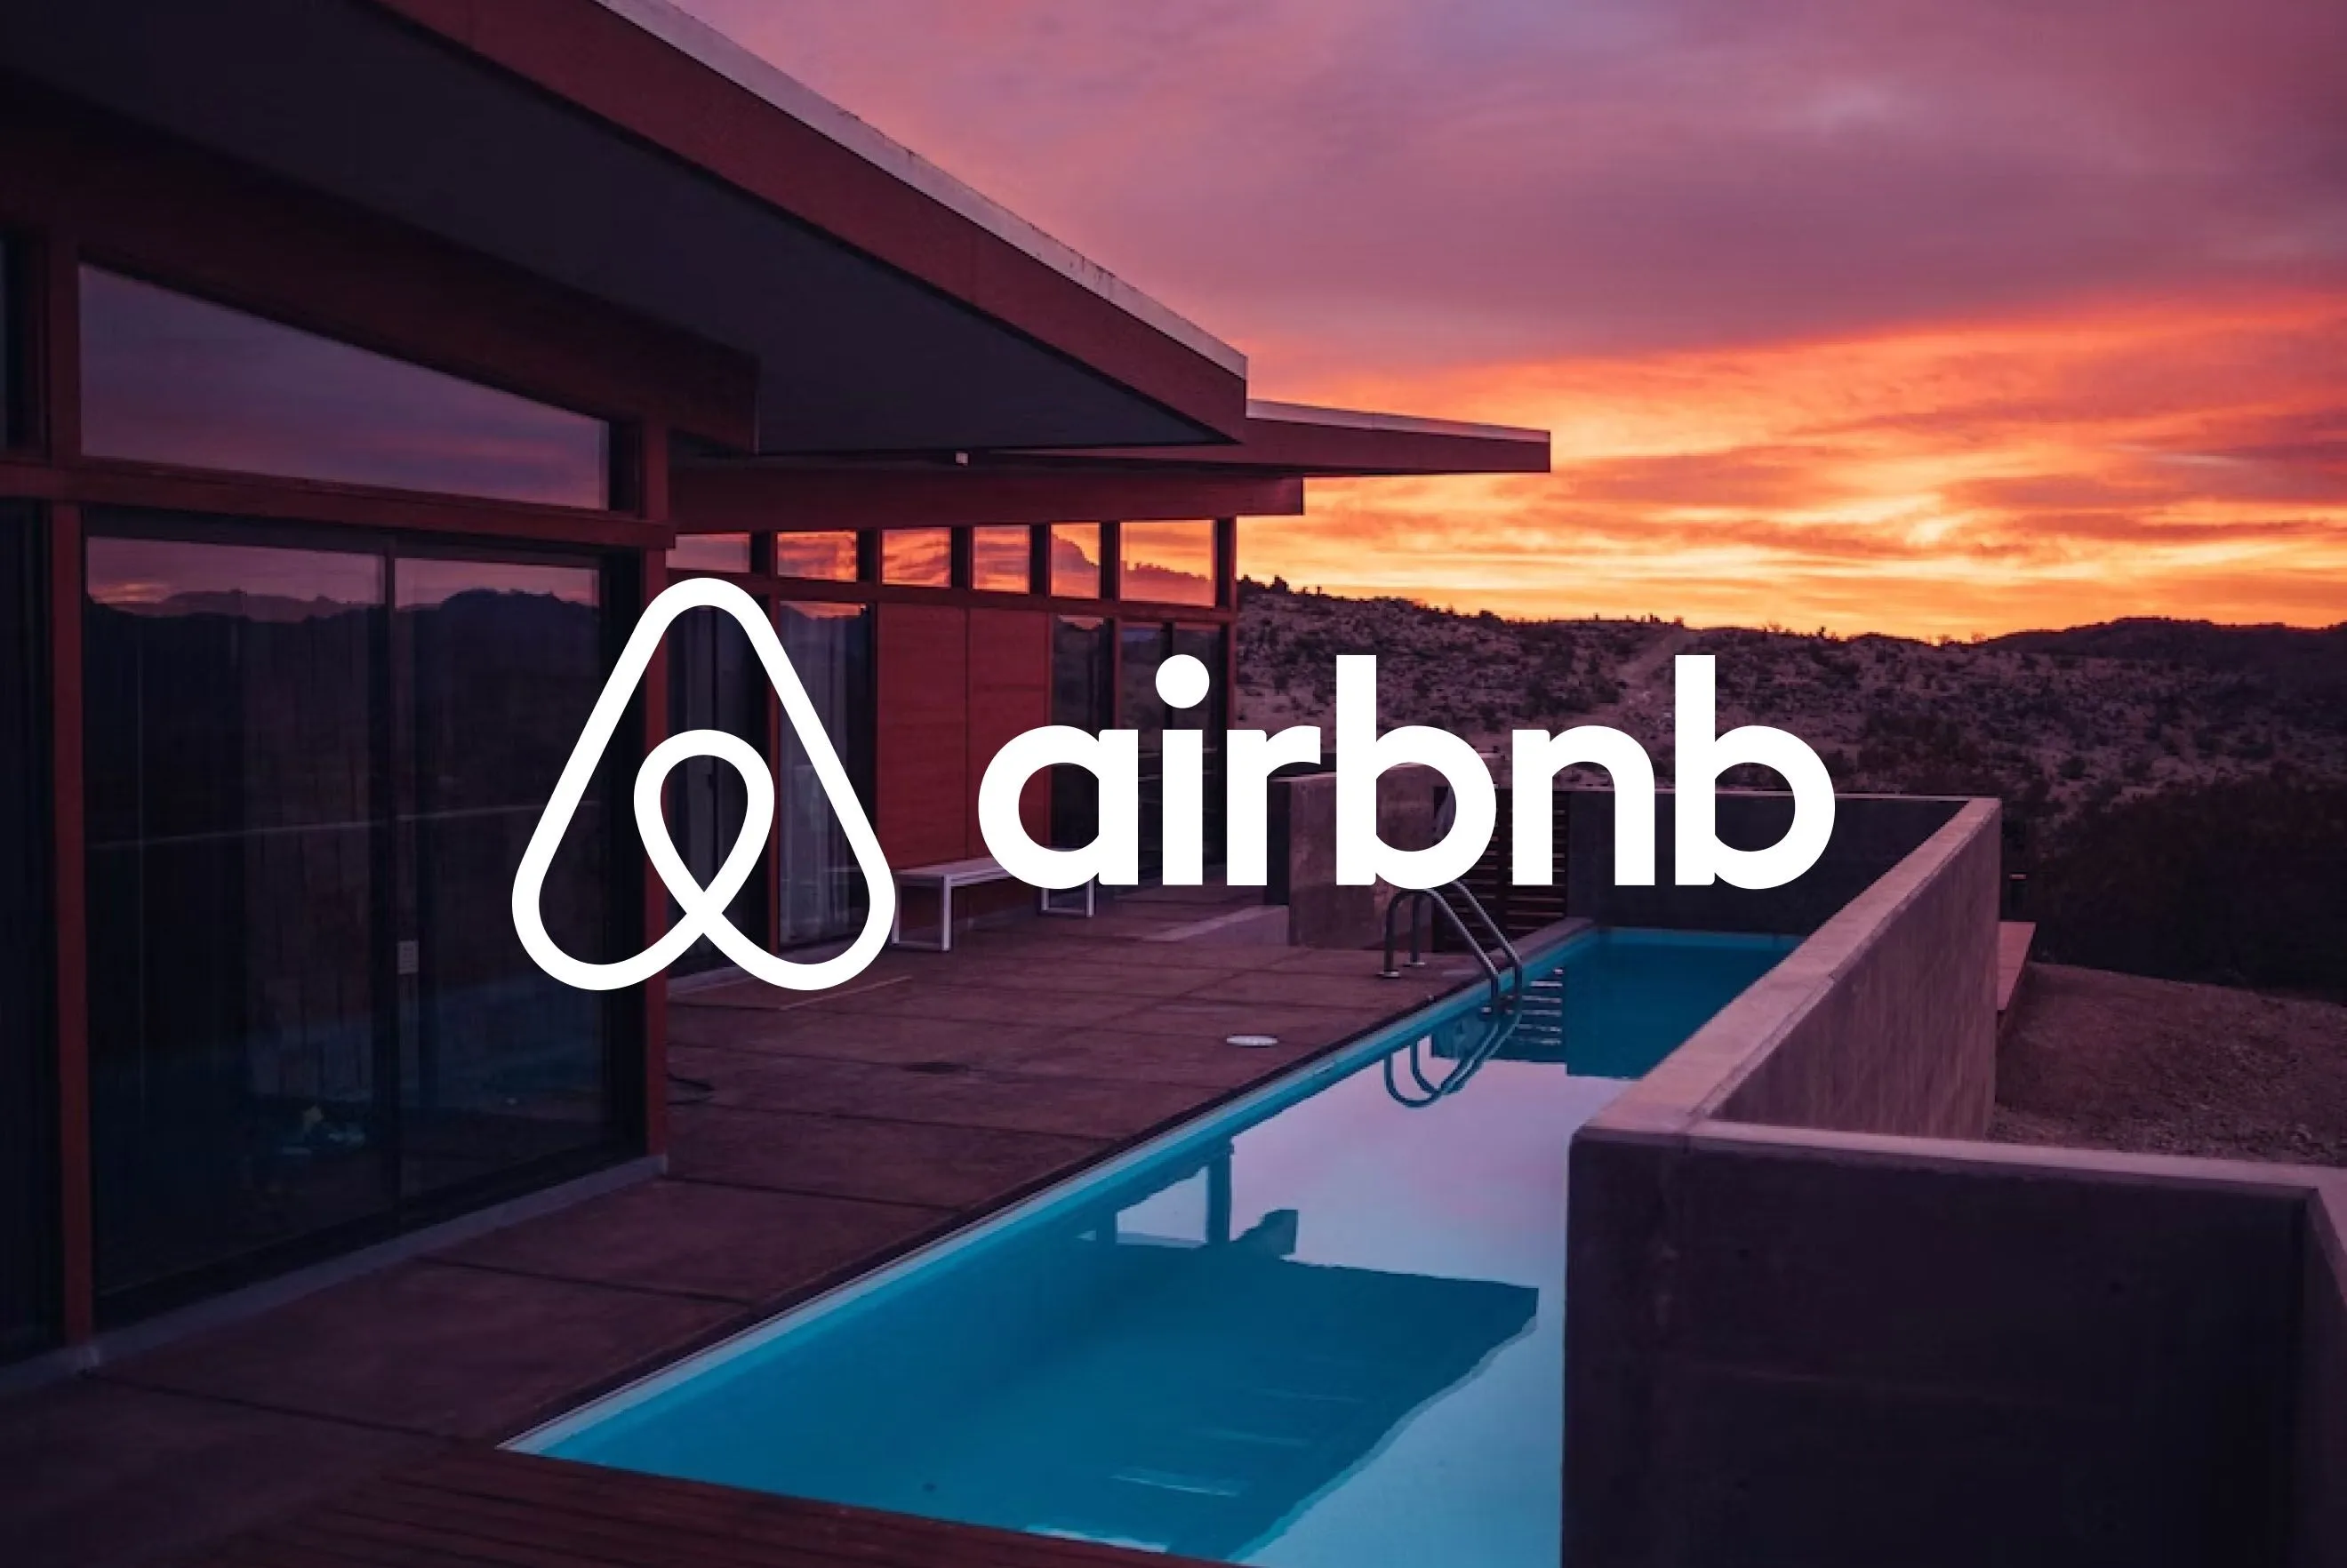

# Deal or No Deal?
## A Predictive Analysis of NYC Airbnb Listings
**Author:** Sam Choe

**DISCLAIMER:** THIS PROJECT HAS NOT BEEN SPONSORED BY AIRBNB AND WAS CONDUCTED AS AN ACADEMIC EXERCISE

## Project Overview
In the vibrant landscape of New York City, where towering skyscrapers adorn the skyline and a dynamic tapestry of cultures converges, one aspect remains consistent: the steep cost of accommodations. With the Big Apple consistently topping the charts for the most expensive lodging in the country, finding affordable yet comfortable options can be a daunting task for both tourists and residents alike.

As highlighted by industry reports, New York City boasts not only high average room rates but also a limited availability of affordable options, particularly in prime locations like Manhattan. This disparity between demand and supply leaves many travelers grappling with exorbitant prices, often compromising their budgets or settling for less desirable accommodations.

Amidst this backdrop, the emergence of platforms like Airbnb has offered a glimmer of hope, presenting travelers with a plethora of alternative lodging options beyond traditional hotels. However, navigating the vast landscape of Airbnb listings in NYC can be overwhelming, with thousands of properties vying for attention, each with its own set of amenities, locations, and price points.

With access to an Airbnb dataset comprised of approximately 67,000 entries, this project aims to uncover the best Airbnbs with good experience qualities in New York City.

## Business Problem
Navigating the bustling streets and vibrant neighborhoods of New York City can be both exhilarating and overwhelming for tourists. The city's sheer size and complexity, coupled with its frenetic pace and diverse cultural landscape, present numerous challenges for visitors seeking to make the most of their experience. Finding the right accomodations does not have to be one of those challenges, with Airbnb offering great deals for the budget conscious tourists. This project aims to understand the attributes of Airbnb listings that contribute to good quality deals.

## Data Understanding
For the project, following dataset was utilized for the analysis:  
- Airbnb Dataset from Kaggle (https://www.kaggle.com/datasets/paramvir705/airbnb-data)

This dataset with 67,122 entries offers a detailed overview of Airbnb listings across the major cities in the U.S. (NYC, LA, SF, DC, Chicago, Boston), providing information on property features, pricing, reviews, and host characteristics. To conduct the comprehensive analysis, we have focused on only NYC Airbnb listings. To understand each listing better, feature engineering was conducted to create items of interest such as the number of amenities provided at the listing, Airbnb host reliability score, as well as an Airbnb experience quality score (our target variable). 

While this dataset is extensive, it is important to note that there were some limitations such as the datset only having listings through late 2017 and most NYC listings being concentrated in the Manhattan and Brooklyn boroughs.

We first start by importing packages and raw data needed to evaluate the business problem.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from xgboost import XGBClassifier

from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import train_test_split as surprise_train_test_split

%matplotlib inline 

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_csv("data/Airbnb_Data.csv")

df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

## Data Preparation

Overall data cleaning steps for the analyses:
1. Handle missing values
2. Standardize number format and change data type
3. Reclassify group categories
4. Aggregate data into reclassified groups

In [4]:
#At first glance, it seems as if there are no duplicates.

df['id'].value_counts(50)

11667455    0.000013
1106505     0.000013
11659752    0.000013
20439529    0.000013
4717034     0.000013
20433388    0.000013
16241135    0.000013
11872752    0.000013
13318642    0.000013
17117683    0.000013
9505268     0.000013
20641847    0.000013
84476       0.000013
8739326     0.000013
5984767     0.000013
7119361     0.000013
14727682    0.000013
9810403     0.000013
8370658     0.000013
4485595     0.000013
4950629     0.000013
14107069    0.000013
14641313    0.000013
3979714     0.000013
21137860    0.000013
16554438    0.000013
19304903    0.000013
11334091    0.000013
13531384    0.000013
16798094    0.000013
17965521    0.000013
4209106     0.000013
14037459    0.000013
14551508    0.000013
2228693     0.000013
12646288    0.000013
12006753    0.000013
4121097     0.000013
16996926    0.000013
6371890     0.000013
18418228    0.000013
3605045     0.000013
16063030    0.000013
15432250    0.000013
5065276     0.000013
18567743    0.000013
16158350    0.000013
9484866     0

In [5]:
#Changing columns with dates as string to datetime

df['first_review'] = pd.to_datetime(df['first_review'])
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_review'] = pd.to_datetime(df['last_review'])

In [6]:
print(df['first_review'].min())
print(df['first_review'].max())

2008-11-17 00:00:00
2017-10-05 00:00:00


In [7]:
print(df['host_since'].min())
print(df['host_since'].max())

2008-03-03 00:00:00
2017-10-04 00:00:00


In [8]:
print(df['last_review'].min())
print(df['last_review'].max())

2009-01-21 00:00:00
2017-10-05 00:00:00


##### A Note About The Dataset

A limitation of this dataset is that it seems a bit dated through end of 2017. It seems like the last date in the dataset is 2017-10-05. Using this value, we calculate the length of being a host.

In [9]:
last_date = df['last_review'].max()

In [10]:
#We have created a host experiences (in years) column

df['host_experience'] = [(last_date - date).days/365 for date in df['host_since']]

In [11]:
#We have the log_price but have also created a price_per_night column

df['price_per_night'] = [np.exp(x) for x in df['log_price']]

In [12]:
#We need to combine the strict categories into one

df['cancellation_policy'].value_counts()

strict             32374
flexible           22545
moderate           19063
super_strict_30      112
super_strict_60       17
Name: cancellation_policy, dtype: int64

In [13]:
#We have reclassified the super strict categories into just strict

df['cancellation_policy'] = df['cancellation_policy'].str.replace('super_strict_30', 'strict')
df['cancellation_policy'] = df['cancellation_policy'].str.replace('super_strict_60', 'strict')

In [14]:
df['cancellation_policy'].value_counts()

strict      32503
flexible    22545
moderate    19063
Name: cancellation_policy, dtype: int64

In [15]:
#We see some entries with null values for bedrooms and bathrooms

df[df['bedrooms'].isna()][['bedrooms', 'bathrooms']].head(20)

,bedrooms,bathrooms
200,NaN,1.0
301,NaN,1.0
2368,NaN,NaN
2842,NaN,NaN
3331,NaN,1.0
6647,NaN,1.0
7155,NaN,1.0
8807,NaN,1.0
10513,NaN,1.0
11584,NaN,1.0


In [16]:
#We will resort to dropping the null values in the bedrooms and bathrooms columns.
#We start with bathrooms because the column has more null values.

df.dropna(subset=['bathrooms'], inplace=True)

In [17]:
#Removing null values in the bathrooms category helped but there are still about 86 null values in the bedrooms column.
#We will also remove the null values in bedrooms

df.dropna(subset=['bedrooms'], inplace=True)

In [18]:
#We create an additional column to keep track of total bedrooms and bathrooms.

df['bedrooms_and_bathrooms'] = df['bedrooms'] + df['bathrooms']

In [19]:
df['city'].value_counts()

NYC        32205
LA         22360
SF          6413
DC          5672
Chicago     3716
Boston      3459
Name: city, dtype: int64

In [20]:
#From this point forward, we start working with the Airbnb listings of that are only based in NYC

df_nyc = df[df['city'] == 'NYC'].reset_index(drop=True)

In [21]:
#We perform value_counts to understand the neighbourhoods in the dataset

df_nyc['neighbourhood'].value_counts(50)

Williamsburg                     0.088549
Bedford-Stuyvesant               0.066807
Bushwick                         0.049477
Upper West Side                  0.043141
Harlem                           0.042551
Hell's Kitchen                   0.040221
Upper East Side                  0.037302
Crown Heights                    0.033295
Astoria                          0.027829
Lower East Side                  0.025810
East Village                     0.025158
East Harlem                      0.024630
Chelsea                          0.022393
Greenpoint                       0.022362
Washington Heights               0.022300
Hamilton Heights                 0.019225
Alphabet City                    0.019132
Clinton Hill                     0.018977
West Village                     0.018760
Park Slope                       0.018604
Flatbush                         0.017051
Midtown East                     0.013666
Lefferts Garden                  0.010560
Kips Bay                         0

In [22]:
#To simplify our analysis, we create a new column 'borough'

bronx_neighbourhoods = ['Mott Haven', 'Concourse', 'Baychester', 'Soundview', 'Riverdale', 'Parkchester', 'Highbridge',
                       'Kingsbridge Heights', 'Bedford Park', 'Concourse Village', 'Bronxdale', 'Tremont', 'Wakefield',
                       'University Heights', 'Park Versailles', 'Kingsbridge', 'Claremont', 'Fordham', 'Eastchester',
                       'Norwood', 'Williamsbridge', 'Allerton', 'Pelham Bay', 'Port Morris', 'City Island',
                       'Crotona', 'Hunts Point', 'Morrisania', 'Morris Heights', 'Longwood', 'Throgs Neck', 'The Bronx',
                       'Melrose', 'Van Nest', 'Mount Eden', 'Castle Hill', 'Castle Hill ', 'Edenwald', 'Morris Park', 'Spuyten Duyvil',
                       'Belmont', 'West Farms', 'Co-op City', 'Woodlawn', 'Westchester Village', 'Country Club']
brooklyn_neighbourhoods = ['Williamsburg', 'Bedford-Stuyvesant', 'Bushwick', 'Crown Heights', 'Greenpoint',
                          'Clinton Hill', 'Park Slope', 'Flatbush', 'Lefferts Garden', 'Fort Greene',
                          'Prospect Heights', 'East Flatbush', 'Carroll Gardens', 'East New York',
                          'Boerum Hill', 'Sunset Park', 'Kensington', 'Windsor Terrace', 'Gowanus',
                          'Greenwood Heights', 'Brooklyn Heights', 'Bay Ridge', 'Downtown Brooklyn', 'Midwood',
                          'Sheepshead Bay', 'Canarsie', 'Brooklyn Navy Yard', 'Cobble Hill', 'Gravesend',
                          'Flatlands', 'Bensonhurst', 'Red Hook', 'DUMBO', 'Brownsville', 'Brighton Beach',
                          'Columbia Street Waterfront', 'Borough Park', 'Coney Island', 'Dyker Heights',
                          'Brooklyn', 'Bath Beach', 'Manhattan Beach', 'Sea Gate', 'Vinegar Hill', 'Bergen Beach',
                          'Marine Park', 'Gerritsen Beach', 'Mill Basin']
manhattan_neighbourhoods = ['Upper West Side', 'Harlem', "Hell's Kitchen", 'Upper East Side', 'Lower East Side',
                           'East Village', 'East Harlem', 'Chelsea', 'Washington Heights', 'Hamilton Heights',
                           'Alphabet City', 'West Village', 'Midtown East', 'Kips Bay', 'Financial District', 
                            'Midtown', 'Chinatown', 'Greenwich Village', 'Morningside Heights', 'Soho',
                           'Gramercy Park', 'Nolita', 'Murray Hill', 'Flatiron District', 
                            'Times Square/Theatre District', 'Inwood', 'Tribeca', 'Union Square', 'Noho', 
                            'Hudson Square', 'Battery Park City', 'Little Italy', 'Meatpacking District', 
                            'Civic Center', 'Manhattan', 'South Street Seaport', 'Marble Hill']
queens_neighbourhoods = ['Astoria', 'Jamaica', 'Ridgewood', 'Sunnyside', 'Flushing', 'Jackson Heights', 
                         'Long Island City', 'Elmhurst', 'Ditmars / Steinway', 'The Rockaways', 'Forest Hills',
                        'Woodside', 'Richmond Hill', 'Roosevelt Island', 'Corona', 'Rego Park', 'Bayside',
                        'Woodhaven', 'Maspeth', 'Kew Garden Hills', 'East Elmhurst', 'Ozone Park', 'Middle Village',
                        'Glendale', 'South Ozone Park', 'College Point', 'Hillcrest', 'Utopia', 'Whitestone',
                        'Howard Beach', 'Lindenwood', 'Queens', 'Fresh Meadows']
staten_neighbourhoods = ['St. George', 'Stapleton', 'West Brighton', 'South Beach', 'Tompkinsville', 'Midland Beach',
                        'Elm Park', 'New Brighton', 'Rosebank', 'Great Kills', 'Westerleigh', 'Tottenville',
                        'Eltingville', 'Grasmere', 'Meiers Corners', 'Concord', 'Randall Manor', 'Port Richmond',
                        'Grymes Hill', 'Castleton Corners', 'New Springville', 'Fort Wadsworth', 'Huguenot',
                        'Mariners Harbor', 'Emerson Hill', 'Silver Lake', 'Graniteville', 'Arrochar', 'Rossville',
                        'Annadale', 'Todt Hill', 'Grant City', 'Lighthouse HIll', 'Oakwood', 'Dongan Hills',
                        'Clifton', 'New Dorp Beach', 'Willowbrook']

def find_neighbourhoods(neighbourhood):
    if isinstance(neighbourhood, str):
        if neighbourhood in bronx_neighbourhoods:
            return "Other"
        if neighbourhood in brooklyn_neighbourhoods:
            return "Brooklyn"
        if neighbourhood in manhattan_neighbourhoods:
            return "Manhattan"
        if neighbourhood in queens_neighbourhoods:
            return "Other"
        if neighbourhood in staten_neighbourhoods:
            return "Other"
    else:
        None
    pass    
    
df_nyc['boroughs'] = df_nyc['neighbourhood'].apply(find_neighbourhoods)

In [23]:
#We observe the null values in the borough category

df_nyc[df_nyc['boroughs'].isna()]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,host_experience,price_per_night,bedrooms_and_bathrooms,boroughs
12537,16429976,4.442651,Bed & Breakfast,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,1.0,Real Bed,flexible,False,NYC,"My place is good for couples, solo adventurers...",2016-10-03,t,f,0%,2016-05-31,f,2016-10-03,40.747266,-73.711750,Your Own Bed room in a Condo close to JFK,NaN,1,100.0,https://a0.muscache.com/im/pictures/152dd61b-0...,11004,1.0,1.0,1.347945,85.0,2.0,None
14658,14153586,4.007333,Apartment,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,flexible,True,NYC,Beautiful small apartment in Floral Park / Gle...,NaT,t,t,100%,2013-09-15,t,NaT,40.746693,-73.710126,"Beautiful Apt in NYC and Long Island, JFK, LGA",NaN,0,NaN,https://a0.muscache.com/im/pictures/9d618fd5-0...,11004.0,2.0,1.0,4.057534,55.0,3.0,None
20740,2146019,4.521789,House,Private room,"{Internet,""Wireless Internet"",""Air conditionin...",1,1.5,Real Bed,strict,True,NYC,Located in a quiet suburban neighborhood Imma...,2017-02-24,t,f,100%,2016-03-31,f,2017-09-17,40.769783,-73.739151,Private Apartment Near NYC Airports,NaN,17,99.0,https://a0.muscache.com/im/pictures/5adba2a1-b...,11363.0,0.0,1.0,1.515068,92.0,1.5,None
22020,17978081,3.970292,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,1.0,Real Bed,moderate,True,NYC,Beautiful home this is room 1 of 3 private bed...,NaT,t,t,100%,2014-07-27,f,NaT,40.757773,-73.729489,Douglaston (apt 2) Room one,NaN,0,NaN,https://a0.muscache.com/im/pictures/b286b55e-8...,11362,1.0,1.0,3.194521,53.0,2.0,None
23645,2794725,4.905275,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,flexible,True,NYC,This apartment features a brand new sectional ...,NaT,t,t,100%,2017-01-05,t,NaT,40.718972,-74.039567,"Beautiful Views of Statue of Liberty, mins to ...",NaN,0,NaN,https://a0.muscache.com/im/pictures/80043240-b...,7302.0,1.0,2.0,0.747945,135.0,2.0,None
27779,169430,4.304065,House,Private room,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",2,1.0,Real Bed,moderate,True,NYC,Spacious 1 bedrooms Suite in lower level/Basem...,2015-09-27,t,f,100%,2015-09-16,t,2017-10-01,40.733515,-73.712992,"""Bloom of Floral Park"" Private 1 BR Suite",NaN,14,97.0,https://a0.muscache.com/im/pictures/107298008/...,11001,1.0,1.0,2.054795,74.0,2.0,None
28007,16769883,3.970292,House,Private room,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",2,1.0,Real Bed,moderate,True,NYC,Beautiful home this is room 2 of 3 private bed...,NaT,t,t,100%,2014-07-27,f,NaT,40.755731,-73.729305,Douglaston (apt2) Room 2,NaN,0,NaN,https://a0.muscache.com/im/pictures/58a0b7e2-e...,11362.0,1.0,1.0,3.194521,53.0,2.0,None
28053,13687532,5.010635,House,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",5,1.5,Real Bed,moderate,True,NYC,Rustic and comfortable country house in the ci...,2017-09-04,t,f,100%,2017-08-11,f,2017-09-17,40.771874,-73.740766,"Garden Oasis in Queens, NYC, 2 blocks from train.",NaN,2,100.0,https://a0.muscache.com/im/pictures/86127e8e-f...,11363.0,3.0,3.0,0.150685,150.0,4.5,None


In [24]:
#We have dropped the null values in the borough category as it was hard to specifically identify these.

df_nyc.dropna(subset=['boroughs'], inplace=True)

In [25]:
df_nyc['boroughs'].value_counts(dropna=False)

Manhattan    14860
Brooklyn     13359
Other         3978
Name: boroughs, dtype: int64

In [26]:
#The next step was to understand the distribution of the review_scores rating

df_nyc['review_scores_rating'].value_counts()

100.0    7091
93.0     1721
96.0     1672
95.0     1555
97.0     1528
98.0     1485
90.0     1451
94.0     1194
80.0     1151
92.0      988
99.0      751
91.0      745
89.0      548
87.0      533
88.0      507
85.0      292
86.0      275
60.0      246
84.0      212
83.0      189
82.0      100
70.0       91
73.0       75
81.0       61
40.0       53
75.0       50
20.0       42
78.0       42
79.0       42
77.0       39
76.0       38
67.0       29
74.0       22
72.0       13
65.0       12
50.0       12
68.0       10
69.0        7
71.0        6
64.0        5
53.0        3
57.0        3
63.0        2
47.0        2
66.0        2
62.0        2
55.0        2
56.0        1
27.0        1
Name: review_scores_rating, dtype: int64

In [27]:
#To understand listings with null score ratings, this was broken out into a separate dataframe.

df_nyc_nullscores = df_nyc[df_nyc['review_scores_rating'].isnull() == True][['host_since','number_of_reviews', 'last_review', 'review_scores_rating']]

In [28]:
#The vast majority of null scores have 0 or 1 reviews

df_nyc_nullscores['number_of_reviews'].value_counts()

0      6800
1       399
2        48
3        17
4         8
15        3
5         3
23        2
8         2
21        1
28        1
36        1
17        1
63        1
33        1
37        1
47        1
6         1
18        1
7         1
19        1
43        1
101       1
Name: number_of_reviews, dtype: int64

In [29]:
#A key finding in the data cleaning process was the following:
#It's important to know that there are listing with no review scores that had more than one review.

df_nyc_nullscores[df_nyc_nullscores['number_of_reviews'] > 1]

,host_since,number_of_reviews,last_review,review_scores_rating
597,2014-03-15,6,2017-01-01,NaN
1064,2013-04-22,2,2016-06-17,NaN
1351,2015-02-25,3,2016-03-15,NaN
1434,2011-05-24,2,2017-07-19,NaN
1482,2013-03-17,15,2017-09-13,NaN
1501,2013-05-25,2,2015-11-21,NaN
1947,2013-10-30,2,2016-03-13,NaN
2258,2012-04-23,2,2017-05-11,NaN
2384,2015-10-14,2,2015-12-16,NaN
2457,2015-01-09,36,2017-09-07,NaN


##### A Point of Consideration for the No Review Scores

To continue with the data cleaning process for the no review scores, some additional research was conducted. However, the results of the research was inconclusive as it is difficult to tell why there are no review scores associated with listings with more than 1 review. One possibility is the fact that these listings could be associated with suspended listings (see Airbnb policy below):

"Airbnb has a strict policy on banning hosts who violate their community standards or terms of service. The company reserves the right to remove a host's listing and suspend or terminate their account if they engage in behavior that is deemed inappropriate, including but not limited to discrimination, harassment, fraudulent activity, or unsafe or illegal conduct."

To handle the no review scores, the following steps were taken:
1) For listings with no reviews, the mean score was assigned.

2) For those with more than 1 review but no review score, it was assumed the host lost credibility and was assigned a 0 rating.


In [30]:
# Calculate the mean rating
mean_rating = df_nyc['review_scores_rating'].mean()

# Create a boolean mask to identify rows with null values and number_of_reviews <= 1
mask = (df_nyc['review_scores_rating'].isnull()) & (df_nyc['number_of_reviews'] <= 1)

# Replace null values that meet the conditions with the mean rating
df_nyc.loc[mask, 'review_scores_rating'] = mean_rating

# Replace other null values with 0
df_nyc['review_scores_rating'].fillna(0, inplace=True)

In [31]:
df_nyc['review_scores_rating'].value_counts()

93.511987     7199
100.000000    7091
93.000000     1721
96.000000     1672
95.000000     1555
97.000000     1528
98.000000     1485
90.000000     1451
94.000000     1194
80.000000     1151
92.000000      988
99.000000      751
91.000000      745
89.000000      548
87.000000      533
88.000000      507
85.000000      292
86.000000      275
60.000000      246
84.000000      212
83.000000      189
82.000000      100
0.000000        97
70.000000       91
73.000000       75
81.000000       61
40.000000       53
75.000000       50
20.000000       42
78.000000       42
79.000000       42
77.000000       39
76.000000       38
67.000000       29
74.000000       22
72.000000       13
65.000000       12
50.000000       12
68.000000       10
69.000000        7
71.000000        6
64.000000        5
53.000000        3
57.000000        3
63.000000        2
47.000000        2
66.000000        2
62.000000        2
55.000000        2
56.000000        1
27.000000        1
Name: review_scores_rating, dty

In [32]:
#A new column review_scores_rating_percentile so that listings in the dataset can be compared more easily

df_nyc['review_scores_rating_percentile'] = stats.rankdata(df_nyc['review_scores_rating'], method='average') / len(df_nyc)

In [33]:
#The amenities column is by far the messiest column in the dataset. There were several steps in the clean up process

df_nyc['amenities'][0]

'{"Wireless Internet","Air conditioning",Kitchen,Heating,"Family/kid friendly",Essentials,"Hair dryer",Iron,"translation missing: en.hosting_amenity_50"}'

In [34]:
#Cleaning up column to remove {} and ""

df_nyc['amenities'] = df_nyc['amenities'].str.replace('{', '').str.replace('}', '').str.replace('"', '')

In [35]:
#A Check to see if the above code has been done correctly.

df_nyc['amenities'][0]

'Wireless Internet,Air conditioning,Kitchen,Heating,Family/kid friendly,Essentials,Hair dryer,Iron,translation missing: en.hosting_amenity_50'

In [36]:
#The codes below finds the unique amenities in the dataset

# Step 1: Extract the 'amenities' column
amenities_column = df_nyc['amenities']

# Step 2: Create an empty set
unique_amenities = set()

# Step 3: Iterate over each row
for row in amenities_column:
    # Step 4: Split the string value by commas
    amenities_list = row.split(',')

    # Step 5: Iterate over each amenity
    for amenity in amenities_list:
        # Step 6: Remove leading and trailing spaces
        cleaned_amenity = amenity.strip()

        # Step 7: Add the cleaned amenity to the set
        unique_amenities.add(cleaned_amenity)

# Step 8: Print the unique amenities
print(unique_amenities)

{'Private entrance', '', 'translation missing: en.hosting_amenity_49', 'Air purifier', 'Washer / Dryer', 'Heating', 'Cable TV', 'Crib', 'Dog(s)', 'Changing table', 'Laptop friendly workspace', 'Long term stays allowed', 'Outlet covers', 'Kitchen', 'Hangers', 'Pets allowed', 'Hot tub', 'Ethernet connection', 'Flat', 'Free parking on street', 'Bathtub', 'Safety card', 'Essentials', 'Smoking allowed', 'Dishes and silverware', 'Accessible-height bed', 'Wheelchair accessible', 'Lock on bedroom door', 'Game console', 'Cooking basics', 'Babysitter recommendations', 'Elevator', 'Baby bath', 'Cat(s)', 'Wide doorway', 'Other', 'Stair gates', 'Beachfront', 'Luggage dropoff allowed', 'Disabled parking spot', 'Fire extinguisher', 'Firm mattress', 'BBQ grill', 'Coffee maker', 'Host greets you', 'Washer', 'Patio or balcony', 'Extra pillows and blankets', 'Table corner guards', 'Family/kid friendly', 'Air conditioning', 'Bed linens', 'Private living room', 'Other pet(s)', 'EV charger', 'Beach essentia

In [37]:
#Have identified 117 unique amenities but the output needs some cleaning

len(unique_amenities)

117

In [38]:
#We are cleaning up the Unique Amenities
unique_amenities.remove('')
unique_amenities.remove('translation missing: en.hosting_amenity_49')
unique_amenities.remove('translation missing: en.hosting_amenity_50')

In [39]:
len(unique_amenities)

114

In [40]:
unique_amenities_list = sorted(unique_amenities)

In [41]:
unique_amenities_list

['24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with shower chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower & toilet',
 'Flat',
 'Free parking on premises',
 'Free parking on street',
 'Game console',
 'Garden or backyard',
 'Ground floor access',
 '

In [42]:
#Now we create an amenities_count column to figure out how many amenities exist for each listing
df_nyc['amenities_count'] = 0
row_count = 0

for row in df_nyc['amenities']:
    amenities_list = row.split(',')
    cleaned_list = []
    count = 0

    for amenity in amenities_list:
        cleaned_amenity = amenity.strip()
        cleaned_list.append(cleaned_amenity)

    for amenity in cleaned_list:
        if amenity in unique_amenities_list:
            count += 1

    df_nyc.loc[row_count, 'amenities_count'] = count
    row_count += 1

In [43]:
#Checking if the amenities_count was done correctly

df_nyc[['amenities','amenities_count']].head()

,amenities,amenities_count
0,"Wireless Internet,Air conditioning,Kitchen,Hea...",8.0
1,"Wireless Internet,Air conditioning,Kitchen,Hea...",14.0
2,"TV,Cable TV,Wireless Internet,Air conditioning...",18.0
3,"Internet,Wireless Internet,Air conditioning,Ki...",14.0
4,"TV,Cable TV,Internet,Wireless Internet,Air con...",18.0


In [44]:
#We have eight unique amenities excluding the last value that doesn't tell us anything. The count is working correctly.

df_nyc['amenities'][0]

'Wireless Internet,Air conditioning,Kitchen,Heating,Family/kid friendly,Essentials,Hair dryer,Iron,translation missing: en.hosting_amenity_50'

In [45]:
#The below is the distribution of the amenities count in the dataset.

df_nyc['amenities_count'].value_counts().head(20)

13.0    2303
14.0    2293
12.0    2198
15.0    2182
16.0    2089
11.0    1898
17.0    1844
10.0    1792
18.0    1672
19.0    1487
9.0     1433
20.0    1299
8.0     1153
21.0    1030
22.0     891
7.0      882
23.0     728
6.0      548
24.0     547
25.0     409
Name: amenities_count, dtype: int64

#### Building Out a Host Reliability Score

The following steps builds up towards a host reliability score. The followings columns were utilized to construct such feature:
- host_has_profile_pic
- host_identity_verified
- host_response_rate
- host_experience

The host reliability score was calculated using an equal weighting of each column to come up with a score.
- 25% x host_has_profile_pic + 25% x host_identity_verified + 25% x host_response_rate + 25% x host_experience_percentile

In [46]:
#To start we will start by cleaning up the host_has_profile_pic and host_identify_verified columns, 
#which has 't' and 'f' as values. We will convert these into 1 and 0, respectively.

df_nyc['host_has_profile_pic'] = df_nyc['host_has_profile_pic'].replace({'t': 1, 'f': 0})
df_nyc['host_identity_verified'] = df_nyc['host_identity_verified'].replace({'t': 1, 'f': 0})

In [47]:
#We move on to cleaning up the host_response_rate, which consists of a good amount of null values

df_nyc[df_nyc['host_response_rate'].isna()][['host_response_rate','number_of_reviews']].head(5)

#What can be observed it that host_response_rate being null value is not necessarily because the hosts are new.
#It is more likely that the null values in the host_response_rate are associated with no responses.

,host_response_rate,number_of_reviews
0,NaN,2.0
14,NaN,0.0
17,NaN,0.0
19,NaN,1.0
23,NaN,0.0


In [48]:
df_nyc['host_response_rate'].value_counts()

100%    17168
90%      1089
80%       576
0%        388
50%       301
70%       247
67%       202
75%       186
60%       181
89%       139
88%       126
83%       125
86%       117
97%       109
92%       106
93%       102
94%        99
95%        98
33%        72
96%        71
91%        69
40%        68
98%        62
99%        55
78%        40
71%        39
25%        39
63%        33
82%        31
57%        31
30%        23
20%        20
87%        18
73%        16
74%        15
79%        15
56%        13
84%        13
29%        13
43%        13
85%        12
81%        11
77%        11
44%        10
55%        10
17%         9
76%         9
64%         9
69%         8
46%         7
38%         7
58%         6
10%         6
53%         4
68%         4
65%         3
22%         3
26%         3
47%         2
14%         2
35%         2
36%         2
54%         2
66%         2
59%         2
27%         1
21%         1
6%          1
61%         1
72%         1
41%         1
62%   

In [49]:
#For the null values, we assign 0% to hosts with null value response rates.
#However, this column is currently an object. As such, we change the column into a type float

df_nyc['host_response_rate'].fillna('0%', inplace=True)
df_nyc['host_response_rate'] = df_nyc['host_response_rate'].str.rstrip('%').astype(float) / 100

In [50]:
#Finally, we take a look at host experience. We first check for any null values

df_nyc[df_nyc['host_experience'].isna()][['id','number_of_reviews','host_experience']]

,id,number_of_reviews,host_experience
35,262343.0,0.0,NaN
47,4588783.0,7.0,NaN
83,18058045.0,6.0,NaN
235,20973084.0,0.0,NaN
249,15629616.0,7.0,NaN
594,5213291.0,39.0,NaN
848,19926959.0,5.0,NaN
955,528357.0,1.0,NaN
1059,6196354.0,1.0,NaN
1210,18045794.0,6.0,NaN


In [51]:
#We see that these values are not available and it is not because the hosts are new.
#Given that it is only 176 rows, we will decide to drop these listings

df_nyc.dropna(subset=['host_experience'], inplace=True)

In [52]:
#We now create a new column host_experience_percentile, which is the percentile ranking of the host experience
df_nyc['host_experience_percentile'] = stats.rankdata(df_nyc['host_experience'], method='average') / len(df_nyc)


In [53]:
#We are now ready to create our host_reliability_score column
#25% x host_has_profile_pic + 25% x host_identity_verified + 25% x host_response_rate + 25% x host_experience_percentile

weights = [0.25, 0.25, 0.25, 0.25]

df_nyc['host_reliability_score'] = np.average(df_nyc[['host_has_profile_pic', 
                                                      'host_identity_verified', 
                                                      'host_response_rate',
                                                      'host_experience_percentile']],
                                              axis=1,
                                              weights=weights
                                             )

In [54]:
#We now create a new column host_experience_percentile, which is the percentile ranking of the host experience
df_nyc['host_reliability_score_percentile'] = stats.rankdata(df_nyc['host_reliability_score'],
                                                             method='average') / len(df_nyc)

In [55]:
#We also create a new column log_price_percentile, which is the percentile ranking of log_price column
df_nyc['log_price_percentile'] = stats.rankdata(df_nyc['log_price'], method='average') / len(df_nyc)

In [56]:
#After the feature engineering process, we are creating a new dataframe with organizing the relevant columns.
#This step helps with the readability of the dataframe

df_nyc_clean = df_nyc[['id',
                       'price_per_night',
                       'log_price',
                       'log_price_percentile', 
                       'neighbourhood',
                       'boroughs',
                       'property_type',
                       'room_type',
                       'bathrooms', 
                       'bedrooms',
                       'bedrooms_and_bathrooms',
                       'beds', 
                       'accommodates', 
                       'amenities_count', 
                       'number_of_reviews', 
                       'review_scores_rating', 
                       'review_scores_rating_percentile', 
                       'host_has_profile_pic', 
                       'host_identity_verified',
                       'host_response_rate',
                       'host_experience',
                       'host_experience_percentile', 
                       'host_reliability_score',
                       'host_reliability_score_percentile']]

In [57]:
df_nyc_clean.head()

,id,price_per_night,log_price,log_price_percentile,neighbourhood,boroughs,property_type,room_type,bathrooms,bedrooms,bedrooms_and_bathrooms,beds,accommodates,amenities_count,number_of_reviews,review_scores_rating,review_scores_rating_percentile,host_has_profile_pic,host_identity_verified,host_response_rate,host_experience,host_experience_percentile,host_reliability_score,host_reliability_score_percentile
0,6901257.0,150.0,5.010635,0.683077,Brooklyn Heights,Brooklyn,Apartment,Entire home/apt,1.0,1.0,2.0,1.0,3.0,8.0,2.0,100.0,0.889897,1.0,1.0,0.00,5.531507,0.872322,0.718081,0.514693
1,6304928.0,169.0,5.129899,0.735213,Hell's Kitchen,Manhattan,Apartment,Entire home/apt,1.0,3.0,4.0,3.0,7.0,14.0,6.0,93.0,0.275243,1.0,0.0,1.00,0.295890,0.038317,0.509579,0.184077
2,7919400.0,145.0,4.976734,0.650084,Harlem,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,3.0,5.0,18.0,10.0,92.0,0.233174,1.0,1.0,1.00,0.945205,0.112719,0.778180,0.585644
3,5578513.0,100.0,4.605170,0.471535,Alphabet City,Manhattan,Apartment,Private room,1.0,1.0,2.0,1.0,2.0,14.0,82.0,93.0,0.275243,1.0,1.0,1.00,4.528767,0.745238,0.936309,0.872369
4,17589436.0,132.0,4.882802,0.617466,Lower East Side,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,2.0,2.0,18.0,26.0,86.0,0.096034,1.0,1.0,0.71,2.136986,0.323918,0.758479,0.563050


In [58]:
#The code below is being used to turn off a warning that is not relevant during our feature engineering process.

pd.options.mode.chained_assignment = None  # default='warn'

##### Creating the Target Variable (Experience Quality)

To create a target variable the assesses whether the Airbnb listing is a good, ok, or bad quality listing, we build up to creating the Experience Quality column. This is built out by doing the following:
1) Define and calculate the experience score for each listing

2) Perform a percentile ranking based on experience score

3) Assign the top, middle, bottom thirds from the percentile rankings to the experience quality column.

In [59]:
#Define and calculate the experience score for the Airbnb listings
#Experience_Score = .5 x review_scores_rating_percentile + .5 x host_reliability_score_percentile

weights = [0.5, 0.5]

df_nyc_clean['experience_score'] = np.average(df_nyc_clean[['review_scores_rating_percentile', 
                                                            'host_reliability_score_percentile']],
                                              axis=1,
                                              weights=weights
                                             )

In [60]:
#We will now do the final percentile ranking based on experience score
df_nyc_clean['experience_score_percentile'] = stats.rankdata(df_nyc_clean['experience_score'], 
                                                             method='average') / len(df_nyc)

In [61]:
#Now we will assign the target variable - Experience Quality
#We assign numerical values for Bad, OK, and Good Qualities as 0, 1, 2, respectively.

for index, row in df_nyc_clean.iterrows():
    if row['experience_score_percentile'] <= (1/3):
        df_nyc_clean.loc[index, 'experience_quality'] = 0
    elif (row['experience_score_percentile'] > (1/3)) and (row['experience_score_percentile'] <= (2/3)):
        df_nyc_clean.loc[index, 'experience_quality'] = 1
    else:
        df_nyc_clean.loc[index, 'experience_quality'] = 2

In [62]:
df_nyc_clean.head()

,id,price_per_night,log_price,log_price_percentile,neighbourhood,boroughs,property_type,room_type,bathrooms,bedrooms,bedrooms_and_bathrooms,beds,accommodates,amenities_count,number_of_reviews,review_scores_rating,review_scores_rating_percentile,host_has_profile_pic,host_identity_verified,host_response_rate,host_experience,host_experience_percentile,host_reliability_score,host_reliability_score_percentile,experience_score,experience_score_percentile,experience_quality
0,6901257.0,150.0,5.010635,0.683077,Brooklyn Heights,Brooklyn,Apartment,Entire home/apt,1.0,1.0,2.0,1.0,3.0,8.0,2.0,100.0,0.889897,1.0,1.0,0.00,5.531507,0.872322,0.718081,0.514693,0.702295,0.801449,2.0
1,6304928.0,169.0,5.129899,0.735213,Hell's Kitchen,Manhattan,Apartment,Entire home/apt,1.0,3.0,4.0,3.0,7.0,14.0,6.0,93.0,0.275243,1.0,0.0,1.00,0.295890,0.038317,0.509579,0.184077,0.229660,0.111017,0.0
2,7919400.0,145.0,4.976734,0.650084,Harlem,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,3.0,5.0,18.0,10.0,92.0,0.233174,1.0,1.0,1.00,0.945205,0.112719,0.778180,0.585644,0.409409,0.350447,1.0
3,5578513.0,100.0,4.605170,0.471535,Alphabet City,Manhattan,Apartment,Private room,1.0,1.0,2.0,1.0,2.0,14.0,82.0,93.0,0.275243,1.0,1.0,1.00,4.528767,0.745238,0.936309,0.872369,0.573806,0.622307,1.0
4,17589436.0,132.0,4.882802,0.617466,Lower East Side,Manhattan,Apartment,Entire home/apt,1.0,1.0,2.0,2.0,2.0,18.0,26.0,86.0,0.096034,1.0,1.0,0.71,2.136986,0.323918,0.758479,0.563050,0.329542,0.243583,0.0


In [63]:
#We have now created our target variable 'experience_quality'

df_nyc_clean['experience_quality'].value_counts(normalize=True)

1.0    0.333333
0.0    0.333333
2.0    0.333333
Name: experience_quality, dtype: float64

## Exploratory Data Analysis

In [64]:
#We are looking at experience quality

df_nyc_clean.groupby(['experience_quality', 'boroughs'])['id'].count()

experience_quality  boroughs 
0.0                 Brooklyn     3916
                    Manhattan    5274
                    Other        1484
1.0                 Brooklyn     4402
                    Manhattan    4935
                    Other        1337
2.0                 Brooklyn     4973
                    Manhattan    4556
                    Other        1145
Name: id, dtype: int64

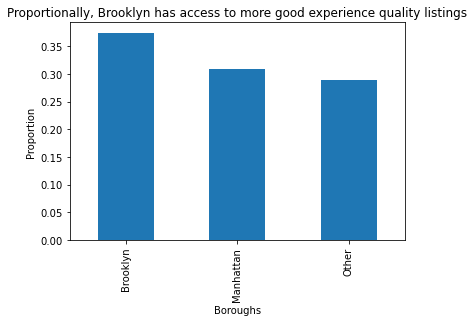

In [65]:
# Calculate the total count for each borough
total_count = df_nyc_clean.groupby('boroughs')['id'].count()

# Calculate the proportion of experience quality '2.0' for each borough
experience_2_count = df_nyc_clean[df_nyc_clean['experience_quality'] == 2.0].groupby('boroughs')['id'].count()
proportion_2 = experience_2_count / total_count

# Sort the proportions in descending order
proportion_2_sorted = proportion_2.sort_values(ascending=False)

# Plot the bar chart
proportion_2_sorted.plot(kind='bar')
plt.xlabel('Boroughs')
plt.ylabel('Proportion')
plt.title("Proportionally, Brooklyn has access to more good experience quality listings")
plt.show()

In [66]:
#We are looking at average price per night by experience quality

df_nyc_clean.groupby('experience_quality')['price_per_night'].mean()


experience_quality
0.0    141.812629
1.0    140.792393
2.0    146.846637
Name: price_per_night, dtype: float64

In [67]:
#We are looking at average price per night by experience quality, but also separating by boroughs

df_nyc_clean.groupby(['experience_quality', 'boroughs'])['price_per_night'].mean()

experience_quality  boroughs 
0.0                 Brooklyn     107.747191
                    Manhattan    179.108836
                    Other         99.157682
1.0                 Brooklyn     113.367333
                    Manhattan    178.099696
                    Other         93.382947
2.0                 Brooklyn     127.316710
                    Manhattan    181.016023
                    Other         95.708297
Name: price_per_night, dtype: float64

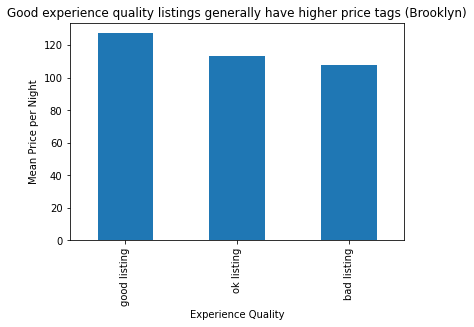

In [68]:
# Filter the data for Brooklyn borough only
brooklyn_data = df_nyc_clean[df_nyc_clean['boroughs'] == 'Brooklyn']

# Calculate the mean values for each experience quality
mean_values = brooklyn_data.groupby('experience_quality')['price_per_night'].mean()

# Rename the experience quality labels
mean_values.rename({0.0: 'bad listing', 1.0: 'ok listing', 2.0: 'good listing'}, inplace=True)

# Sort the mean in descending order
mean_values_sorted = mean_values.sort_values(ascending=False)

# Plot the bar chart
mean_values_sorted.plot(kind='bar')
plt.xlabel('Experience Quality')
plt.ylabel('Mean Price per Night')
plt.title("Good experience quality listings generally have higher price tags (Brooklyn)")
plt.show()

In [69]:
#We are looking at average price per night by experience quality

df_nyc_clean.groupby('experience_quality')['number_of_reviews'].mean()

experience_quality
0.0     9.804103
1.0    21.061270
2.0    23.369215
Name: number_of_reviews, dtype: float64

In [70]:
#We are looking at average price per night by experience quality, but also separating into boroughs

df_nyc_clean.groupby(['experience_quality', 'boroughs'])['number_of_reviews'].mean()

experience_quality  boroughs 
0.0                 Brooklyn      8.262513
                    Manhattan    10.714827
                    Other        10.635445
1.0                 Brooklyn     19.374148
                    Manhattan    22.403445
                    Other        21.661930
2.0                 Brooklyn     22.729540
                    Manhattan    23.071115
                    Other        27.333624
Name: number_of_reviews, dtype: float64

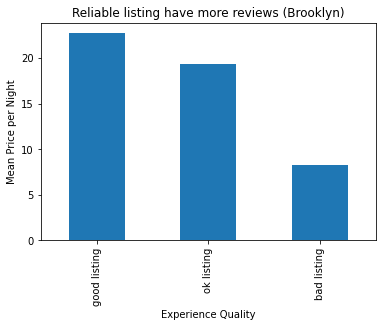

In [71]:
# Filter the data for Brooklyn borough only
brooklyn_data_num = df_nyc_clean[df_nyc_clean['boroughs'] == 'Brooklyn']

# Calculate the mean values for each experience quality
mean_values_num = brooklyn_data_num.groupby('experience_quality')['number_of_reviews'].mean()

# Rename the experience quality labels
mean_values_num.rename({0.0: 'bad listing', 1.0: 'ok listing', 2.0: 'good listing'}, inplace=True)

# Sort the mean in descending order
mean_values_num_sorted = mean_values_num.sort_values(ascending=False)

# Plot the bar chart
mean_values_num_sorted.plot(kind='bar')
plt.xlabel('Experience Quality')
plt.ylabel('Mean Price per Night')
plt.title("Reliable listing have more reviews (Brooklyn)")
plt.show()

In [72]:
#We are looking at amenities count by experience quality

df_nyc_clean.groupby('experience_quality')['amenities_count'].mean()

experience_quality
0.0    15.108956
1.0    15.781432
2.0    16.455968
Name: amenities_count, dtype: float64

In [73]:
#We are looking at amenities count by experience quality, but also separating into boroughs

df_nyc_clean.groupby(['experience_quality', 'boroughs'])['amenities_count'].mean()

experience_quality  boroughs 
0.0                 Brooklyn     14.919305
                    Manhattan    15.319492
                    Other        14.861186
1.0                 Brooklyn     15.530668
                    Manhattan    15.927862
                    Other        16.066567
2.0                 Brooklyn     16.520611
                    Manhattan    16.307287
                    Other        16.766812
Name: amenities_count, dtype: float64

# Modeling

For the modeling process, the preprocessing steps included standard scaling the numerical columns while one hot encoding the categorical column. Models explored were mainly classification centric, with logistics regression, random forest classifier, gradient boosting, and XG Boost classifiers performed and evaluated. The accuracy score was used to compare performance models as the focus was to know how often these models made correct predictions.

In [74]:
#Understanding the data types in the df_nyc_clean dataframe

df_nyc_clean.dtypes

id                                   float64
price_per_night                      float64
log_price                            float64
log_price_percentile                 float64
neighbourhood                         object
boroughs                              object
property_type                         object
room_type                             object
bathrooms                            float64
bedrooms                             float64
bedrooms_and_bathrooms               float64
beds                                 float64
accommodates                         float64
amenities_count                      float64
number_of_reviews                    float64
review_scores_rating                 float64
review_scores_rating_percentile      float64
host_has_profile_pic                 float64
host_identity_verified               float64
host_response_rate                   float64
host_experience                      float64
host_experience_percentile           float64
host_relia

In [75]:
#Defining our X and y variables
# Independent variables - price_per_night, boroughs, bathrooms, bedrooms, amenities_count, number_of_reviews
# Dependent variable - experience quality

X = df_nyc_clean[['price_per_night', 'boroughs', 'bathrooms', 'bedrooms', 'amenities_count', 'number_of_reviews']]
y = df_nyc_clean['experience_quality']

In [76]:
#Conducting a train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=100)

In [77]:
X.head()

,price_per_night,boroughs,bathrooms,bedrooms,amenities_count,number_of_reviews
0,150.0,Brooklyn,1.0,1.0,8.0,2.0
1,169.0,Manhattan,1.0,3.0,14.0,6.0
2,145.0,Manhattan,1.0,1.0,18.0,10.0
3,100.0,Manhattan,1.0,1.0,14.0,82.0
4,132.0,Manhattan,1.0,1.0,18.0,26.0


In [78]:
# Creating a Column Transformer for our preprocessing steps

CT = ColumnTransformer(transformers=[('ss', StandardScaler(), [0, 2, 3, 4, 5]), 
                                     ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), [1])],
                       remainder='passthrough')

### Creating Baseline Model

In [79]:
#We are adding our Baseline model - The Dummy Classifier

baseline_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('dummy', DummyClassifier(strategy='most_frequent'))])

In [80]:
baseline_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

In [81]:
baseline_model_pipe.score(X_train, y_train)

0.33456862091938705

In [82]:
baseline_model_pipe.score(X_test, y_test)

0.3296277791656258

### First Simple Model

In [83]:
#We are adding our first simple model (fsm) - Logistics Regression

fsm_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('logreg', LogisticRegression(multi_class='multinomial', 
                                                                   random_state=100))])

In [84]:
fsm_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('logreg',
                 LogisticRegression(multi_class='multinomial',
                                    random_state=100))])

In [85]:
fsm_model_pipe.score(X_train, y_train)

0.41389073950699534

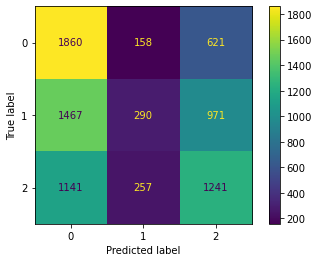

In [86]:
#Confusion Matrix of First Simple Model

y_pred_fsm = fsm_model_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_fsm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [87]:
fsm_model_pipe.score(X_test, y_test)

0.42355733200099926

In [88]:
accuracy_score(y_test, y_pred_fsm)

0.42355733200099926

In [89]:
precision_score(y_test, y_pred_fsm, labels=[0], average='micro')

0.41629364368845123

In [90]:
precision_score(y_test, y_pred_fsm, labels=[1], average='micro')

0.41134751773049644

In [91]:
precision_score(y_test, y_pred_fsm, labels=[2], average='micro')

0.4380515354747617

### Gridsearching

In [92]:
#Implementing Gridsearch to find best logistics regression parameters

parameters = {'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1],
             'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag']}

gs = GridSearchCV(estimator=fsm_model_pipe,
                 param_grid=parameters,
                 cv=5)

In [93]:
gs.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1])])),
                                       ('logreg',
                                        LogisticRegression(multi_class='multinomial',
                                                           random_state=100))]),
             param_grid={'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1],
                         'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                            'sag']})

In [94]:
gs.best_params_

{'logreg__C': 0.1, 'logreg__solver': 'lbfgs'}

### Best LogReg Model

In [95]:
#Using the best parameters from GridSearchCV to run best Logistics Regression model

best_logreg_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('best_logreg', LogisticRegression(multi_class='multinomial',
                                                                        C=0.1, 
                                                                        solver='lbfgs', 
                                                                        random_state=100))])

In [96]:
best_logreg_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('best_logreg',
                 LogisticRegression(C=0.1, multi_class='multinomial',
                                    random_state=100))])

In [97]:
best_logreg_model_pipe.score(X_train, y_train)

0.41389073950699534

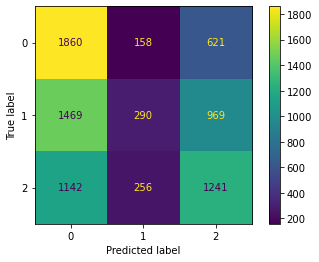

In [98]:
#Confusion Matrix of Best LogReg Model

y_pred_bestlog = best_logreg_model_pipe.predict(X_test)
cm_bestlog = confusion_matrix(y_test, y_pred_bestlog)

disp_bestlog = ConfusionMatrixDisplay(confusion_matrix=cm_bestlog)

disp_bestlog.plot();

In [99]:
best_logreg_model_pipe.score(X_test, y_test)

0.42355733200099926

In [100]:
accuracy_score(y_test, y_pred_bestlog)

0.42355733200099926

In [101]:
precision_score(y_test, y_pred_bestlog, labels=[0], average='micro')

0.41601431447103554

In [102]:
precision_score(y_test, y_pred_bestlog, labels=[1], average='micro')

0.4119318181818182

In [103]:
precision_score(y_test, y_pred_bestlog, labels=[2], average='micro')

0.43836100317908866

In [104]:
bestlog_coef = best_logreg_model_pipe.named_steps['best_logreg'].coef_
bestlog_col_names = best_logreg_model_pipe.named_steps['ct'].get_feature_names_out()

bestlog_coef_df = pd.DataFrame(bestlog_coef, columns=bestlog_col_names)

bestlog_coef_df

,ss__price_per_night,ss__bathrooms,ss__bedrooms,ss__amenities_count,ss__number_of_reviews,ohe__boroughs_Brooklyn,ohe__boroughs_Manhattan,ohe__boroughs_Other
0,-0.035165,0.035783,0.005092,-0.079082,-0.389144,-0.169862,0.069149,0.088321
1,-0.020368,0.000506,0.004695,-0.002335,0.168494,0.017339,0.003499,-0.006419
2,0.055533,-0.036289,-0.009787,0.081417,0.220650,0.152523,-0.072648,-0.081902


## Random Forest Classifier

In [105]:
#To improve our results, we start looking at an ensemble technique, random forest classifier

rfc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('rfc', RandomForestClassifier(max_features='sqrt',
                                                                   max_samples=0.3,
                                                                   random_state=100))])

In [106]:
rfc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('rfc',
                 RandomForestClassifier(max_samples=0.3, random_state=100))])

In [107]:
rfc_model_pipe.score(X_train, y_train)

0.8378164556962026

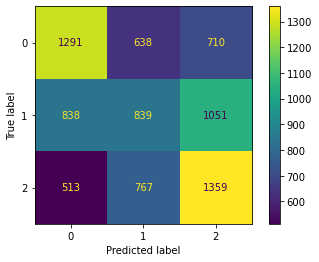

In [108]:
#Confusion Matrix of Random Forest Classifier

y_pred_rfc = rfc_model_pipe.predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

disp_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_rfc)

disp_rfc.plot();

In [109]:
rfc_model_pipe.score(X_test, y_test)

0.43579815138646016

In [110]:
accuracy_score(y_test, y_pred_rfc)

0.43579815138646016

In [111]:
precision_score(y_test, y_pred_rfc, labels=[0], average='micro')

0.4886449659348978

In [112]:
precision_score(y_test, y_pred_rfc, labels=[1], average='micro')

0.3738859180035651

In [113]:
precision_score(y_test, y_pred_rfc, labels=[2], average='micro')

0.4355769230769231

##### Note about the model performance

We had the Random Forest Classifier perform well on the train data but the performance drops off considerably with the test data. This is an indication that the model has overfit. We will try to correct for this through the following model tuning steps.

In [114]:
#Implementing Gridsearch to find best logistics regression parameters

parameters_rfc = {'rfc__criterion': ['gini','entropy', 'log_loss'],
             'rfc__max_depth': [2, 3, 4, 5],
                 'rfc__min_samples_leaf': [10, 100, 1000]}

gs_rfc = GridSearchCV(estimator=rfc_model_pipe,
                 param_grid=parameters_rfc,
                 cv=5)

In [115]:
gs_rfc.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1])])),
                                       ('rfc',
                                        RandomForestClassifier(max_samples=0.3,
                                                               random_state=100))]),
             param_grid={'rfc__criterion': ['gini', 'entropy', 'log_loss'],
                         'rfc__max_depth': [2, 3, 4, 5],
                         'rfc__min_samples_leaf': [10, 100, 1000]})

In [116]:
gs_rfc.best_params_

{'rfc__criterion': 'entropy',
 'rfc__max_depth': 5,
 'rfc__min_samples_leaf': 100}

### Best Random Forest Classifier

In [117]:
#Using the best parameters from GridSearchCV to run best Random Forest Classifer model

best_rfc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('best_rfc', RandomForestClassifier(criterion='entropy',
                                                                    max_depth=5,
                                                                    max_features='sqrt',
                                                                   max_samples=0.3,
                                                                    min_samples_leaf=100,
                                                                   random_state=100))])

In [118]:
best_rfc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('best_rfc',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        max_samples=0.3, min_samples_leaf=100,
                                        random_state=100))])

In [119]:
best_rfc_model_pipe.score(X_train, y_train)

0.46727181878747504

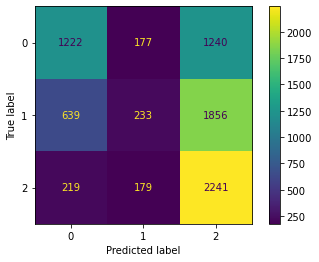

In [120]:
#Confusion Matrix of Best Random Forest Classifier

y_pred_best_rfc = best_rfc_model_pipe.predict(X_test)
cm_best_rfc = confusion_matrix(y_test, y_pred_best_rfc)

disp_best_rfc = ConfusionMatrixDisplay(confusion_matrix=cm_best_rfc)

disp_best_rfc.plot();

In [121]:
best_rfc_model_pipe.score(X_test, y_test)

0.4616537596802398

In [122]:
accuracy_score(y_test, y_pred_best_rfc)

0.4616537596802398

In [123]:
precision_score(y_test, y_pred_best_rfc, labels=[0], average='micro')

0.5875

In [124]:
precision_score(y_test, y_pred_best_rfc, labels=[1], average='micro')

0.39558573853989815

In [125]:
precision_score(y_test, y_pred_best_rfc, labels=[2], average='micro')

0.41989881956155145

In [126]:
#We get a list of feature importance from the best random forest classifier

importance_rfc = best_rfc_model_pipe.named_steps['best_rfc'].feature_importances_
col_name_rfc = best_rfc_model_pipe.named_steps['ct'].get_feature_names_out()

feature_importances_rfc = dict(zip(col_name_rfc, importance_rfc))

print(feature_importances_rfc)

{'ss__price_per_night': 0.07964900407024324, 'ss__bathrooms': 0.006518084138502797, 'ss__bedrooms': 0.014527434671403053, 'ss__amenities_count': 0.05250542771520434, 'ss__number_of_reviews': 0.7831218515162905, 'ohe__boroughs_Brooklyn': 0.03657718482633962, 'ohe__boroughs_Manhattan': 0.019873620872743587, 'ohe__boroughs_Other': 0.007227392189272699}


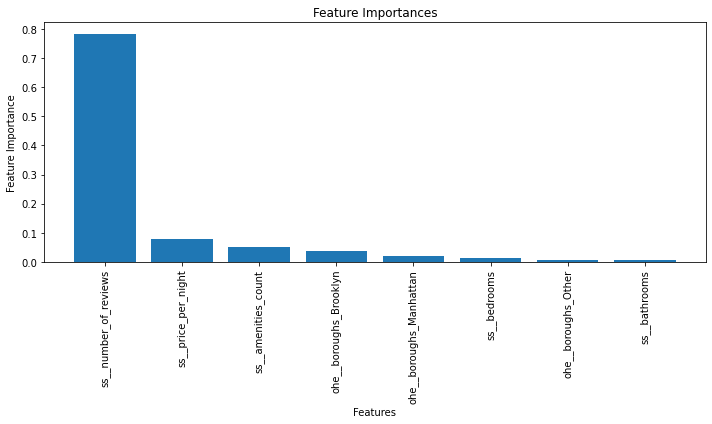

In [127]:
#We display the list of feature importance as a bar chart

sorted_indices_rfc = np.argsort(importance_rfc)[::-1]
sorted_importance_rfc = importance_rfc[sorted_indices_rfc]
sorted_col_name_rfc = col_name_rfc[sorted_indices_rfc]

plt.figure(figsize=(10, 6))
plt.bar(sorted_col_name_rfc, sorted_importance_rfc)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show();

## Gradient Boosting

In [128]:
#We evaluate another ensemble technique, gradient boosting classifier

gbc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('gbc', GradientBoostingClassifier(max_features='sqrt', random_state=100))])

In [129]:
gbc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('gbc',
                 GradientBoostingClassifier(max_features='sqrt',
                                            random_state=100))])

In [130]:
gbc_model_pipe.score(X_train, y_train)

0.48342771485676217

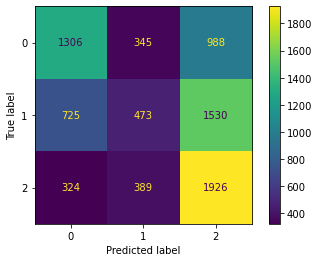

In [131]:
#Confusion Matrix of Gradient Boosting Classifier

y_pred_gbc = gbc_model_pipe.predict(X_test)
cm_gbc = confusion_matrix(y_test, y_pred_gbc)

disp_gbc = ConfusionMatrixDisplay(confusion_matrix=cm_gbc)

disp_gbc.plot();

In [132]:
gbc_model_pipe.score(X_test, y_test)

0.46277791656257805

In [133]:
accuracy_score(y_test, y_pred_gbc)

0.46277791656257805

In [134]:
precision_score(y_test, y_pred_gbc, labels=[0], average='micro')

0.5545647558386412

In [135]:
precision_score(y_test, y_pred_gbc, labels=[1], average='micro')

0.39188069594034797

In [136]:
precision_score(y_test, y_pred_gbc, labels=[2], average='micro')

0.43339333933393337

##### Note about the model performance

Initial gradient boosting seems to perform better than random forest classifier. We will model tune to see if we can improve the results.

In [137]:
#Implementing Gridsearch to find best gradient boosting classifier parameters

parameters_gbc = {'gbc__n_estimators': [100, 200, 300],
                 'gbc__max_depth': [2, 3, 4, 5]}

gs_gbc = GridSearchCV(estimator=gbc_model_pipe,
                 param_grid=parameters_gbc,
                 cv=5)

In [138]:
gs_gbc.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1])])),
                                       ('gbc',
                                        GradientBoostingClassifier(max_features='sqrt',
                                                                   random_state=100))]),
             param_grid={'gbc__max_depth': [2, 3, 4, 5],
                         'gbc__n_estimators': [100, 200, 300]})

In [139]:
gs_gbc.best_params_

{'gbc__max_depth': 4, 'gbc__n_estimators': 100}

### Best Gradient Boosting Classifier

In [140]:
#Using the best parameters from GridSearchCV to run best Gradient Boosting Classifer model

best_gbc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('best_gbc', GradientBoostingClassifier(max_features='sqrt', 
                                                                             max_depth=4,
                                                                             n_estimators=100,
                                                                             random_state=100))])

In [141]:
best_gbc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('best_gbc',
                 GradientBoostingClassifier(max_depth=4, max_features='sqrt',
                                            random_state=100))])

In [142]:
best_gbc_model_pipe.score(X_train, y_train)

0.4994586942038641

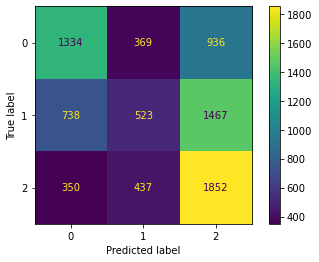

In [143]:
#Confusion Matrix of Best Gradient Boosting Classifier

y_pred_best_gbc = best_gbc_model_pipe.predict(X_test)
cm_best_gbc = confusion_matrix(y_test, y_pred_best_gbc)

disp_best_gbc = ConfusionMatrixDisplay(confusion_matrix=cm_best_gbc)

disp_best_gbc.plot();

In [144]:
best_gbc_model_pipe.score(X_test, y_test)

0.4632775418436173

In [145]:
accuracy_score(y_test, y_pred_best_gbc)

0.4632775418436173

In [146]:
precision_score(y_test, y_pred_best_gbc, labels=[0], average='micro')

0.550784475639967

In [147]:
precision_score(y_test, y_pred_best_gbc, labels=[1], average='micro')

0.3935289691497366

In [148]:
precision_score(y_test, y_pred_best_gbc, labels=[2], average='micro')

0.4352526439482961

In [149]:
#We get a list of feature importance from the best gradient boosting classifier

importance_gbc = best_gbc_model_pipe.named_steps['best_gbc'].feature_importances_
col_name_gbc = best_gbc_model_pipe.named_steps['ct'].get_feature_names_out()

feature_importances_gbc = dict(zip(col_name_gbc, importance_gbc))

print(feature_importances_gbc)

{'ss__price_per_night': 0.11310304554229995, 'ss__bathrooms': 0.03322485594088794, 'ss__bedrooms': 0.03623460232407223, 'ss__amenities_count': 0.05996485270898026, 'ss__number_of_reviews': 0.6989465437886877, 'ohe__boroughs_Brooklyn': 0.03063917314614881, 'ohe__boroughs_Manhattan': 0.02034796967235351, 'ohe__boroughs_Other': 0.00753895687656966}


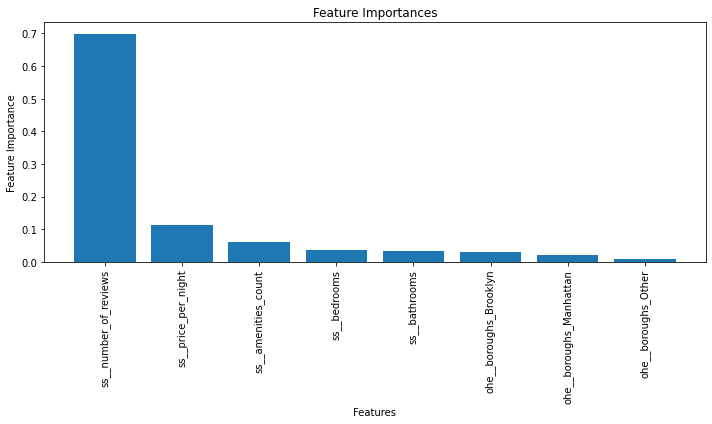

In [150]:
#We display the list of feature importance as a bar chart

sorted_indices_gbc = np.argsort(importance_gbc)[::-1]
sorted_importance_gbc = importance_gbc[sorted_indices_gbc]
sorted_col_name_gbc = col_name_gbc[sorted_indices_gbc]

plt.figure(figsize=(10, 6))
plt.bar(sorted_col_name_gbc, sorted_importance_gbc)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show();

## XG Boost Classifier

In [151]:
#We evaluate another ensemble technique, XGBoost Classifier

xgbc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('xgbc', XGBClassifier(objective='multi:softmax', random_state=100))])

In [152]:
xgbc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [153]:
xgbc_model_pipe.score(X_train, y_train)

0.596477348434377

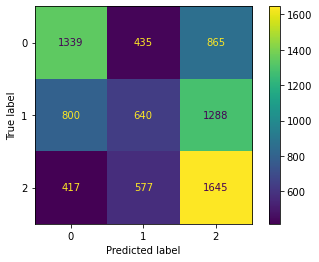

In [154]:
#Confusion Matrix of XGBoost Classifier

y_pred_xgbc = xgbc_model_pipe.predict(X_test)
cm_xgbc = confusion_matrix(y_test, y_pred_xgbc)

disp_xgbc = ConfusionMatrixDisplay(confusion_matrix=cm_xgbc)

disp_xgbc.plot();

In [155]:
xgbc_model_pipe.score(X_test, y_test)

0.45266050462153384

In [156]:
accuracy_score(y_test, y_pred_xgbc)

0.45266050462153384

In [157]:
precision_score(y_test, y_pred_xgbc, labels=[0], average='micro')

0.5238654147104851

In [158]:
precision_score(y_test, y_pred_xgbc, labels=[1], average='micro')

0.387409200968523

In [159]:
precision_score(y_test, y_pred_xgbc, labels=[2], average='micro')

0.4331226961558715

##### Note about model performance

Similar to the Random Forest Model, there is evidence that there is overfitting. We will model tune to try to improve results.

In [160]:
#Implementing Gridsearch to find best XGBoost classifier parameters

parameters_xgbc = {'xgbc__n_estimators': [100, 200, 300],
                 'xgbc__max_depth': [2, 3, 4, 5]}

gs_xgbc = GridSearchCV(estimator=xgbc_model_pipe,
                 param_grid=parameters_xgbc,
                 cv=5)

In [161]:
gs_xgbc.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ss',
                                                                         StandardScaler(),
                                                                         [0, 2,
                                                                          3, 4,
                                                                          5]),
                                                                        ('ohe',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         [1])])),
                                       ('xgbc',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0, gpu_id=-1,
                                                      importance_...
                                                      max_depth=6,
                                                      min_child_weight=1,
                                                      missing=nan,
                                                      monotone_constraints='()',
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      objective='multi:softprob',
                                                      random_state=100,
                                                      reg_alpha=0, reg_lambda=1,
                                                      scale_pos_weight=None,
                                                      subsample=1,
                                                      tree_method='exact',
                                                      validate_parameters=1,
                                                      verbosity=None))]),
             param_grid={'xgbc__max_depth': [2, 3, 4, 5],
                         'xgbc__n_estimators': [100, 200, 300]})

In [162]:
gs_xgbc.best_params_

{'xgbc__max_depth': 2, 'xgbc__n_estimators': 100}

### Best XGBoost Classifier

In [163]:
#Using the best parameters from GridSearchCV to run best Gradient Boosting Classifer model

best_xgbc_model_pipe = Pipeline(steps=[('ct', CT),
                                     ('best_xgbc', XGBClassifier(objective='multi:softmax', 
                                                                 max_depth=2,
                                                                 n_estimators=100,
                                                                 random_state=100))])

In [164]:
best_xgbc_model_pipe.fit(X_train, y_train)

C:\Users\Admin\anaconda3\envs\learn-env\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', StandardScaler(),
                                                  [0, 2, 3, 4, 5]),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  [1])])),
                ('best_xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=2, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', random_state=100,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [165]:
best_xgbc_model_pipe.score(X_train, y_train)

0.4817621585609594

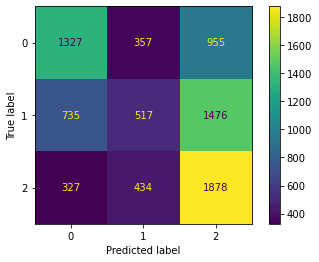

In [166]:
#Confusion Matrix of Best XGBoost Classifier

y_pred_best_xgbc = best_xgbc_model_pipe.predict(X_test)
cm_best_xgbc = confusion_matrix(y_test, y_pred_best_xgbc)

disp_best_xgbc = ConfusionMatrixDisplay(confusion_matrix=cm_best_xgbc)

disp_best_xgbc.plot();

In [167]:
best_xgbc_model_pipe.score(X_test, y_test)

0.46490132400699474

In [168]:
accuracy_score(y_test, y_pred_best_xgbc)

0.46490132400699474

In [169]:
precision_score(y_test, y_pred_best_xgbc, labels=[0], average='micro')

0.5554625366262035

In [170]:
precision_score(y_test, y_pred_best_xgbc, labels=[1], average='micro')

0.3952599388379205

In [171]:
precision_score(y_test, y_pred_best_xgbc, labels=[2], average='micro')

0.4358319795776282

In [172]:
#We get a list of feature importance from the best XGBoost classifier

importance_xgbc = best_xgbc_model_pipe.named_steps['best_xgbc'].feature_importances_
col_name_xgbc = best_xgbc_model_pipe.named_steps['ct'].get_feature_names_out()

feature_importances_xgbc = dict(zip(col_name_xgbc, importance_xgbc))

print(feature_importances_xgbc)

{'ss__price_per_night': 0.050726064, 'ss__bathrooms': 0.043728765, 'ss__bedrooms': 0.043752577, 'ss__amenities_count': 0.035589706, 'ss__number_of_reviews': 0.48632088, 'ohe__boroughs_Brooklyn': 0.26971, 'ohe__boroughs_Manhattan': 0.03815916, 'ohe__boroughs_Other': 0.032012887}


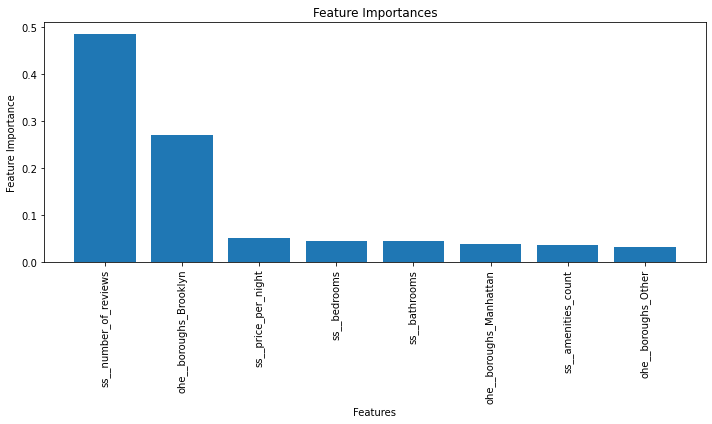

In [173]:
#We display the list of feature importance as a bar chart

sorted_indices_xgbc = np.argsort(importance_xgbc)[::-1]
sorted_importance_xgbc = importance_xgbc[sorted_indices_xgbc]
sorted_col_name_xgbc = col_name_xgbc[sorted_indices_xgbc]

plt.figure(figsize=(10, 6))
plt.bar(sorted_col_name_xgbc, sorted_importance_xgbc)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show();

## Modeling Takeaways

Taking the feature importance from one of our best performing models (XG Boost Classifier - performed best on the test set), it became evident that there were features that mattered more than others when considering Airbnb listings. Most notable were the top three: 1) Number of Reviews, 2) Being Brooklyn based, and 3) Price Per Night of the listing.

Why do these features matter? From our logistics regression modeling, we have come to understand the odds related to securing good experience quality Airbnb listings. More specifically, we have learned that:
- For each 1% increase in number of reviews, the odds of a good listing goes up by 25%
- For a 1% increase in association with Brooklyn, the odds of a good listing goes up by 16%.
- For a 1% increase in the listing’s Price Per Night, the odds of a good listing goes up by 6%.

# Recommendations

After compiling the results from our modeling process, we were able to derive three concrete recommendations for the budget conscious tourists.

**1) Tourists should focus on Brooklyn Airbnb listings for better deals.** Just this action will allow tourists to have increased chances of having a better experience at the Airbnb of their choice.

**2) Target Airbnb listings with more than 20 reviews.** This is because the more reliable listings generally have more reviews as previous guests were happy to leave positive feedback for the hosts. On the flipside, bad listings generally had lower number of feedback offered by guests. While there may be a number of reasons why this may be, one thing clear is that it is better to go for the known quality.

**3) Pay a slight premium of up to 10-20% to secure better Airbnb listings.** When one focuses on going for the cheapest deal, there is a risk of landing a listing that goes from mediocre to downright awful. Don’t fall for the trap and steer clear.


# Conclusion

Visiting New York City can certainly break the bank, but budget conscious tourists can surely find deals on platforms such as Airbnb.

To have the most success in finding a great Airbnb listing, tourists should:

1. Focus on Brooklyn Airbnb listings
2. Target listings with more than 20 reviews
3. Pay a slight premium of up to 10-20% to secure better deals.

We hope these suggestions allow for people to plan a better NYC trip.